In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### Introduction
- 항상 데이터셋이 크고 정돈이 되어있지 않을 때, 데이터가 텍스트, 이미지, 등의 형식이 모두 다르고 깔끔하게 적재되어 있지 않았기 때문에 모델은 잘 설계를 했음에도 학습에 문제가 생긴다거나 model.fit을 하는 과정에서 차원이 안맞는등의 문제가 많이 발생했었기 때문에 **대규모 데이터셋을 효율적으로 전처리**하는 방법을 배워보고 싶었다.
- 이 단원을 공부하면서 **텐서플로를 이용해서 dataset을 잘 다룰 수 있으면 좋겠다.**

- 이 notebook은 개념을 책을 보며 공부한 내용및 코드를 정리해 놓은 것이고, 다른 notebook에 연습문제를 풀었다.


**딥러닝의 핵심은 사실 신경망도 맞지만 이러한 대량의 데이터를 얼마나 효율적으로 적재, 파실, 전처리 하는지에 달려있다.**

#### Before we Begin
1. 텐서플로의 데이터 API는 데이터의 효율적인 전처리에 많은 도움을 준다.
    - 예를 들면 데이터셋 객체를 만들고 데이터를 읽어올 위치와 변환 방법을 지정해 주기만 하면 되기 때문이다.
    - 텍스트 파일(CSV 파일), 이진 파일, SQL database, google big query등 다양한 종류의 데이터를 이용할 수 있다.
2. 직접 전처리 층을 만들서나 keras의 표준 전처리 층을 이용하거나 one-hot encoding, BoW encoding, embedding등 다양한 방법이 존재한다.  



3. 이 단원에서는 API, TFRecord format을 다루고 사용자 전처리 층을 만드는 방법과 표준 keras 전처리 층을 사용하는 방법을 다룬다.

### 13.1 데이터 API
- 데이터 API의 중심에는 dataset이 존재하고 이는 **연속된 데이터 샘플**이다.

In [14]:
x = tf.range(8)
dataset = tf.data.Dataset.from_tensor_slices(x)
dataset

<TensorSliceDataset shapes: (), types: tf.int32>

In [15]:
for item in dataset:print(item)

tf.Tensor(0, shape=(), dtype=int32)
tf.Tensor(1, shape=(), dtype=int32)
tf.Tensor(2, shape=(), dtype=int32)
tf.Tensor(3, shape=(), dtype=int32)
tf.Tensor(4, shape=(), dtype=int32)
tf.Tensor(5, shape=(), dtype=int32)
tf.Tensor(6, shape=(), dtype=int32)
tf.Tensor(7, shape=(), dtype=int32)


- ```from_tensor_slices()```함수는 텐서를 받아서 첫번째 차원을 따라 x의 각 원소가 tf.data.Dataset을 만든다. 그리고 이 dataset은 10개의 0부터 9까지의 값에 해당하는 item을 갖는다.
    - 만약에 우리가 이미지의 픽셀 데이터를(```tf.io.read_file(), tf.image.decode_jpeg(), tf.cast(image, tf.float32)```)와같은 tensorflow의 image 모듈로 바꾸었다면 tensor의 형태일 것이기 때문에 ```from_tensor_slices()```에 넣어서 처리해도 좋다.
    
#### 13.1.1 연쇄 변환 
- 데이터셋이 준비 되면 변환 메서드를 호출하여 여러 종류의 변환이 수행 가능하다.
- 아래의 코드는 먼저 dataset을 3번 반복해서 나열하고 앞에서부터 7개씩, 즉 batch_size만큼 추출한다.
- 만약 batch()메서드에 ```drop_remainder = True```를 덧붙이게 되면 batch_size만큼 자르다가 batch_size에 못미치는 크기는 과감하게 버릴 것을 의미한다.

In [16]:
dataset = dataset.repeat(3).batch(7)
for item in dataset:print(item)

tf.Tensor([0 1 2 3 4 5 6], shape=(7,), dtype=int32)
tf.Tensor([7 0 1 2 3 4 5], shape=(7,), dtype=int32)
tf.Tensor([6 7 0 1 2 3 4], shape=(7,), dtype=int32)
tf.Tensor([5 6 7], shape=(3,), dtype=int32)


- ```map()```메서드를 이용해서 아이템, 즉 dataset에 있는 요소들을 변환하는 것이 가능하다.
- 이 함수는 데이터에 원하는 어떤 전처리 작업에도 자유롭게 사용이 가능하다. 
    - 예를 들면 이미지 크기 변환, 회전 등의 복잡한 계산을 포함할 때에 여러 thread로 나누어 속도를 높이는 것이 가능한데, 이때 ```num_parallel_calls```매개변수를 지정하면 된다.

- map()가 각 아이템에 변환을 주는 반면 apply()는 데이터셋 전체에 변환을 적용한다.

- ```filter()```을 이용해서는 데이터셋을 필터링도 할 수 있다.
- ```take()```는 데이터셋의 몇개의 아이템만을 보고 싶을 때 보고싶은 개수를 넣어 이용한다.

In [19]:
dataset = dataset.map(lambda x: x*2)
dataset = dataset.apply(tf.data.experimental.unbatch())
dataset = dataset.filter(lambda x : x<10)
for item in dataset.take(3):
    print(item)

Instructions for updating:
Use `tf.data.Dataset.unbatch()`.
tf.Tensor(0, shape=(), dtype=int32)
tf.Tensor(8, shape=(), dtype=int32)
tf.Tensor(0, shape=(), dtype=int32)


#### 13.1.2 Data Shuffling
- 경사 하강법은 훈련 세트의 샘플이 독립적이고 동일한 분포일 때 최고의 성능을 발휘할 수 있다.
- shuffle()을 이용해서 샘플을 섞어야 하는데, 먼저 item을 buffer_size만큼 추출하여 채우고 새로운 아이템이 요청되면 random하게 이 안에서 추출하게 된다. 
- buffer_size는 데이터의 크기보다 크게 할 필요는 없지만 충분히 크게 설정하는 것이 중요하다. (완벽한 shuffle을 위해서는 데이터셋의 크기와 동일하게 설정하는 것이 좋다.)
- 그리고 실행할 때 마다 shuffle의 순서를 동일하게 하기 위해 random_seed를 부여해 주어야 한다.

In [20]:
dataset = tf.data.Dataset.range(10).repeat(3)
dataset = dataset.shuffle(buffer_size = 5, seed = 42).batch(7)
for item in dataset:
    print(item)

tf.Tensor([0 2 3 6 7 9 4], shape=(7,), dtype=int64)
tf.Tensor([5 0 1 1 8 6 5], shape=(7,), dtype=int64)
tf.Tensor([4 8 7 1 2 3 0], shape=(7,), dtype=int64)
tf.Tensor([5 4 2 7 8 9 9], shape=(7,), dtype=int64)
tf.Tensor([3 6], shape=(2,), dtype=int64)


- 샘플을 더 섞기 위해서 원본데이터를 여러 파일로 나눈 뒤에 훈련하는 동안 무작위로 읽는 방법도 존재한다.
- 이를 위해 파일을 여러개를 무작위로 선택하고 파일에서 동시에 읽은 레코드를 돌아가면서 반환이 가능하다.
#### 13.1.2-1. 여러 파일에서 한 줄씩 번갈아 읽기

In [32]:
dataset_path ="C:\\Users\\이지혜\\.keras\\datasets\\img_align_celeba"
import os
#os.path.join()을 이용해서 root directory에 담긴 모든 파일의 저장 경로를 반환하고 이를 tf.data.Datasett.list_files()를 이용해서 파일 경로를 섞은 데이터셋을 반환한다.
#기본적으로 shuffle을 해준 상태를 반환해 주기 때문에 random_seed를 설정해 주는 것도 좋다.
dataset_file = tf.data.Dataset.list_files(os.path.join(dataset_path, '*.jpg'))

In [33]:
for i in dataset_file.take(5):
    print(i)

tf.Tensor(b'C:\\Users\\\xec\x9d\xb4\xec\xa7\x80\xed\x98\x9c\\.keras\\datasets\\img_align_celeba\\012883.jpg', shape=(), dtype=string)
tf.Tensor(b'C:\\Users\\\xec\x9d\xb4\xec\xa7\x80\xed\x98\x9c\\.keras\\datasets\\img_align_celeba\\009949.jpg', shape=(), dtype=string)
tf.Tensor(b'C:\\Users\\\xec\x9d\xb4\xec\xa7\x80\xed\x98\x9c\\.keras\\datasets\\img_align_celeba\\012823.jpg', shape=(), dtype=string)
tf.Tensor(b'C:\\Users\\\xec\x9d\xb4\xec\xa7\x80\xed\x98\x9c\\.keras\\datasets\\img_align_celeba\\018118.jpg', shape=(), dtype=string)
tf.Tensor(b'C:\\Users\\\xec\x9d\xb4\xec\xa7\x80\xed\x98\x9c\\.keras\\datasets\\img_align_celeba\\004734.jpg', shape=(), dtype=string)


In [35]:
#inter_leave()메서드를 이용해서 한번에 다섯개의 파일을 번갈아 가면서 읽는다.
#inter_leave()를 이용하면 n_reader의 크기만큼 데이터를 불러와서 이를 새로운 데이터셋으로 만드는데, 이 경우에는 list_files으로 바꾼다.
n_readers = 5
dataset = dataset_file.interleave(
    lambda filepath:tf.data.Dataset.list_files(filepath).skip(1), cycle_length = n_readers
)

Cause: could not parse the source code:

    lambda filepath:tf.data.Dataset.list_files(filepath).skip(1), cycle_length = n_readers

This error may be avoided by creating the lambda in a standalone statement.

Cause: could not parse the source code:

    lambda filepath:tf.data.Dataset.list_files(filepath).skip(1), cycle_length = n_readers

This error may be avoided by creating the lambda in a standalone statement.



In [36]:
for i in dataset_file.take(5):
    print(i.numpy())

b'C:\\Users\\\xec\x9d\xb4\xec\xa7\x80\xed\x98\x9c\\.keras\\datasets\\img_align_celeba\\008284.jpg'
b'C:\\Users\\\xec\x9d\xb4\xec\xa7\x80\xed\x98\x9c\\.keras\\datasets\\img_align_celeba\\018117.jpg'
b'C:\\Users\\\xec\x9d\xb4\xec\xa7\x80\xed\x98\x9c\\.keras\\datasets\\img_align_celeba\\014359.jpg'
b'C:\\Users\\\xec\x9d\xb4\xec\xa7\x80\xed\x98\x9c\\.keras\\datasets\\img_align_celeba\\016978.jpg'
b'C:\\Users\\\xec\x9d\xb4\xec\xa7\x80\xed\x98\x9c\\.keras\\datasets\\img_align_celeba\\018516.jpg'


#### 13.1.3 데이터 전처리
- California Housing Dataset을 이용하기로 한다.

- 데이터를 다운로드 하기 전에 제일 중요한 것은 다른 저장소에 있던 데이터이기 때문에 해당 데이터에 접근 권한이 있어야 하며 데이터의 구조를 잘 알고 있어야 한다는 것이다.
- 데이터를 다운받는 함수를 만들면 **데이터가 정기적으로 바뀔때 유용**하다. 

In [52]:
import os
import tarfile
import urllib.request

DOWNLOAD_ROOT = 'https://raw.githubusercontent.com/rickiepark/handson-ml2/master/'
HOUSING_PATH = os.path.join('datasets', 'housing')
HOUSING_URL = DOWNLOAD_ROOT + 'datasets/housing/housing.tgz'

**fetch_housing_data()를 호출하게 되면 현재 작업 공간에 'dataset/housing'이라는 directory를 만들고 housing.tgz파일을 내려 받은 뒤에 같은 directory에 압축을 풀어 housing.csv파일을 만든다.**

In [184]:
def fetch_housing_data(housing_url = HOUSING_URL, housing_path = HOUSING_PATH):
    os.makedirs(housing_path, exist_ok = True)
    tgz_path = os.path.join(housing_path, 'housing.tgz')
    #tgz_path는 저장소이고(내 pc에 저장될 저장소의 디렉토리), housing_url은 문서의 url주소이다.
    urllib.request.urlretrieve(housing_url, tgz_path)
    #압축된 데이터의 압축을 풀기위해 extraxtall을 이용한다.
    #파이썬과 마찬가지로 여기서도 open을 이용해 지정된 디렉토리에 파일을 저장한다.
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path = housing_path)
    housing_tgz.close()

#### 여기서 잠깐 파이썬의 urlretrieve 와 urlopen에 대해서 알아보고 가자.
- urlretrieve는 URL로 표시된 네트워크 객체(URL 주소의 문서)를 로컬 파일로 저장, 즉 직접 다운로드가 가능하다.

```urllib.request.urlretrieve(url, 로컬에 저장될 파일 이름)```

- urlopen은 URL로 표시된 네트워크 객체를 파이썬 실행환경의 메모리로 로드한다.



In [58]:
def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)

In [59]:
fetch_housing_data()

In [60]:
df = load_housing_data()

In [61]:
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [63]:
x_mean = np.mean(df, axis = 0)

In [65]:
x_mean

longitude               -119.569704
latitude                  35.631861
housing_median_age        28.639486
total_rooms             2635.763081
total_bedrooms           537.870553
population              1425.476744
households               499.539680
median_income              3.870671
median_house_value    206855.816909
dtype: float64

In [66]:
x_std = np.std(df, axis = 0)

In [67]:
x_std

longitude                  2.003483
latitude                   2.135901
housing_median_age        12.585253
total_rooms             2181.562402
total_bedrooms           421.374759
population              1132.434688
households               382.320491
median_income              1.899776
median_house_value    115392.820404
dtype: float64

In [68]:
n_inputs = 8
def preprocess(line):
    defs = [0.]*n_inputs + [tf.constant([], dtype = tf.float32)]
    fields = tf.io.decode_csv(line, record_defaults = defs)
    x = tf.stack(fields[:-1])
    y = tf.stack(fields[-1:])
    return (x-x_mean)/x_std, y

#### califfornia housing dataset을 여러개의 csv파일로 나누기
- 이 데이터셋은 크기가 그렇게 크지 않아서 여러개의 파일로 나누는 것이 큰 의미가 없을 수는 있지만 **메모리에 맞지 않는 큰 데이터셋의 경우**에는 **일반적으로 먼저 여러개의 파일로 나누고 tensorflow에서 이 파일을 병렬로 읽도록**한다.

In [73]:
from sklearn.datasets import fetch_california_housing
housing = fetch_california_housing()

In [77]:
housing['target'].reshape(-1,1)

array([[4.526],
       [3.585],
       [3.521],
       ...,
       [0.923],
       [0.847],
       [0.894]])

데이터를 들여다 보면 'data'라는 항목과 'target'이라는 항목이 존재하는데 'target'이 바로 예측하고자 하는 주택 가격이다.

In [79]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(housing['data'], housing['target'].reshape(-1,1), random_state = 42)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, random_state = 42)

In [172]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(x_train)
x_mean = scaler.mean_
x_std = scaler.scale_

In [173]:
x_mean

array([ 3.89175860e+00,  2.86245478e+01,  5.45593655e+00,  1.09963474e+00,
        1.42428122e+03,  2.95886657e+00,  3.56464315e+01, -1.19584363e+02])

데이터 정규화를 할 때에 원래 **훈련용 데이터의 mean과 std**를 사용해서 나머지 test, val 데이터도 정규화를 한다.

In [174]:
mean = np.mean(x_train, axis = 0)
mean

array([ 3.89175860e+00,  2.86245478e+01,  5.45593655e+00,  1.09963474e+00,
        1.42428122e+03,  2.95886657e+00,  3.56464315e+01, -1.19584363e+02])

In [84]:
std = np.std(x_train, axis = 0)

In [91]:
train_data = np.concatenate([x_train, y_train], axis = 1)
test_data = np.concatenate([x_test, y_test], axis = 1)
val_data = np.concatenate([x_val, y_val], axis =1)

In [136]:
#train, test, val data로 나누었으니 이제는 각각의 데이터를 여러개의 csv파일로 나누어서 각각 따로 저장하자.
#저장 경로를 만드는 이유는 나중에 pd.read_csv()를 이용해서 csv파일을 읽어야 하기 때문이다.
def save_to_multiple(data, name, header = None, n_parts = 10):
    path = os.path.join('datasets', 'housing')
    os.makedirs(path, exist_ok = True)
    path_format = os.path.join(path, '{}_{:02d}.csv')
    
    filepaths = []
    m = len(data)
    for idx, file_name in enumerate(np.array_split(np.arange(m), n_parts)):
        #소분한 csv 데이터의 저장 경로의 세부 이름 설정
        part_csv = path_format.format(name, idx)
        #return할 리스트에 해당 저장 경로의 이름 저장
        filepaths.append(part_csv)
        #직접 .write()를 이용해서 array의 형태를 csv파일 형태로 바꾸어서 저장을 한다.
        #part_csv에 저장된 데이터를 읽고 encoding을 한뒤에 header이 있다면 header을 입력해 넣고 아니라면 데이터의 내용 자체를 적는다.
        with open(part_csv, "wt", encoding="utf-8") as f:
            if header is not None:
                f.write(header)
                f.write("\n")
            for row_idx in file_name:
                f.write(",".join([repr(col) for col in data[row_idx]]))
                f.write("\n")
    return filepaths

In [128]:
header_cols = housing.feature_names + ["MedianHouseValue"]
header = ",".join(header_cols)

In [129]:
train_filepaths = save_to_multiple(train_data, 'train', header, n_parts = 20)
test_filepaths = save_to_multiple(test_data, 'test', header,n_parts = 10)
val_filepaths = save_to_multiple(val_data, 'val', header, n_parts = 10)

In [130]:
train_filepaths

['datasets\\housing\\train_00.csv',
 'datasets\\housing\\train_01.csv',
 'datasets\\housing\\train_02.csv',
 'datasets\\housing\\train_03.csv',
 'datasets\\housing\\train_04.csv',
 'datasets\\housing\\train_05.csv',
 'datasets\\housing\\train_06.csv',
 'datasets\\housing\\train_07.csv',
 'datasets\\housing\\train_08.csv',
 'datasets\\housing\\train_09.csv',
 'datasets\\housing\\train_10.csv',
 'datasets\\housing\\train_11.csv',
 'datasets\\housing\\train_12.csv',
 'datasets\\housing\\train_13.csv',
 'datasets\\housing\\train_14.csv',
 'datasets\\housing\\train_15.csv',
 'datasets\\housing\\train_16.csv',
 'datasets\\housing\\train_17.csv',
 'datasets\\housing\\train_18.csv',
 'datasets\\housing\\train_19.csv']

In [131]:
pd.read_csv(train_filepaths[0]).head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedianHouseValue
0,3.5214,15.0,3.049945,1.106548,1447.0,1.605993,37.63,-122.43,1.442
1,5.3275,5.0,6.490060,0.991054,3464.0,3.443340,33.69,-117.39,1.687
2,3.1000,29.0,7.542373,1.591525,1328.0,2.250847,38.44,-122.98,1.621
3,7.1736,12.0,6.289003,0.997442,1054.0,2.695652,33.55,-117.70,2.621
4,2.0549,13.0,5.312457,1.085092,3297.0,2.244384,33.93,-116.93,0.956


In [135]:
with open(train_filepaths[0]) as f:
    for i in range(5):
        print(f.readline())

MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedianHouseValue

3.5214,15.0,3.0499445061043287,1.106548279689234,1447.0,1.6059933407325193,37.63,-122.43,1.442

5.3275,5.0,6.490059642147117,0.9910536779324056,3464.0,3.4433399602385686,33.69,-117.39,1.687

3.1,29.0,7.5423728813559325,1.5915254237288134,1328.0,2.2508474576271187,38.44,-122.98,1.621

7.1736,12.0,6.289002557544757,0.9974424552429667,1054.0,2.6956521739130435,33.55,-117.7,2.621



**여기에서 파일을 읽고 쓰는 방법은 다른 어떤 언어나 플랫폼도 아닌 python이다. 우선 파이썬으로 파일을 읽고 쓰는 방법을 간단히 정리하고 넘어가고자 한다.**
1. 프로그램을 실행한 디렉토리에 파일을 저장하고 싶다고 해보자. 그 쉬운 방법으로 파이썬의 내장함수 **open**이 존재한다.  
    ```f = open('새파일.txt', 'w')
    f.close()```
    - 파일을 생성하기 위해 사용한 이 함수는 '파일 이름'과 '파일 열기 모드'를 입력값으로 받고 파일 객체를 결괏값으로 돌려준다.
    - ```f = open("C:/doit/새파일.txt", 'w')``` 새 파일을 'C:/doit/새파일.txt'라는 directory에 저장하고 싶을 때는 저렇게 한다.
    - 'r'은 읽기 모드, 'w'는 쓰기 모드, 'a'는 추가 모드이다.
2. 우리는 아직까지 파일을 저장만 했지 아무것도 쓰지는 않았다. 이때 사용하는 파이썬의 내장함수는 **write**이다.     
```py3
f = open("C:/doit/새파일.txt", 'w')
for i in range(1, 11):
   data = "%d번째 줄입니다.\n" % i
   f.write(data)```

**지금까지의 내용은 현재 프로그램에 저장한 것이고, 외부 저장소의 데이터를 다루는 방법도 보아야 한다.**
1. ```f = open("C:/doit/새파일.txt", 'r')```이런 식으로 함수를 열고
2. ```line = f.readline()```이렇게 'readline()'을 이용해 한 줄 씩 불러올 수도 있고
3. 'readlines()'를 이용해서 전체 데이터를 한 줄 씩읽어 올 수도 있다.
4. with 문과 함께 사용한다면
```with open("foo.txt", "w") as f:
    f.write("Life is too short, you need python")```
이렇게 할 수도 있다.

In [185]:
def preprocess(line):
    defs = [0.]*n_inputs + [tf.constant([], dtype = tf.float32)]
    fields = tf.io.decode_csv(line, record_defaults = defs)
    x = tf.stack(fields[:-1])
    y = tf.stack(fields[-1:])
    return (x-mean)/std, y

In [176]:
preprocess(b'4.2083,44.0,5.3232,0.9171,846.0,2.3370,37.47,-122.2,2.782')

(<tf.Tensor: shape=(8,), dtype=float32, numpy=
 array([ 0.16579159,  1.216324  , -0.05204564, -0.39215982, -0.5277444 ,
        -0.2633488 ,  0.8543046 , -1.3072058 ], dtype=float32)>,
 <tf.Tensor: shape=(1,), dtype=float32, numpy=array([2.782], dtype=float32)>)

위의 preprocessing 함수는 그 이전에 interleave()메서드를 이용해서 소분된 csv파일중에 한번에 5개씩, 각 줄마다 데이터를 읽고 또 불러오는 방식을 취하는 데이터셋으로 구성했기 때문에 이제는 평균값으로 빼고 표준편차로 나누는 정규화 과정을 진행해야 한다.

이 함수에서는 record_default값, 즉 데이터에서 누락된 값은 defs로 지정해 주는 방법으로 0으로 대체하게 될 것이고, ```tf.io.decode_csv```를이용할때에는 parsing을 진행할 line과 각 열에 대한 기본 값을 담은 배열을 입력값으로 넣어 주어야 한다. 따라서 실수의 형태의, 누락된 값을 0으로 채운다는 정보를 tensorflow에 전달하는 것이다.

decode_csv()는 각 열마다 한개씩 스칼라 텐서의 리스트를 반환하고, 우리는 1D텐서 배열이 필요하기 때문에 tf.stack()를 이용해서 x값과 target을 나누어 튜플의 형태로 반환하게 된다

In [140]:
tf.constant([], dtype = tf.float32)

<tf.Tensor: shape=(0,), dtype=float32, numpy=array([], dtype=float32)>

In [141]:
[0.]*5 + [tf.constant([], dtype = tf.float32)]

[0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 <tf.Tensor: shape=(0,), dtype=float32, numpy=array([], dtype=float32)>]

#### Making Input Pipelines

In [186]:
def csv_reader_dataset(filepaths, repeat = 1, n_readers = 5, n_read_threads=None, shuffle_buffer_size = 10000, n_parse_threads = 5, batch_size = 32):
    dataset = tf.data.Dataset.list_files(filepaths).repeat(repeat)
    dataset = dataset.interleave(
        lambda filepath:tf.data.TextLineDataset(filepath).skip(1), cycle_length = n_readers, num_parallel_calls = n_read_threads)
    dataset = dataset.shuffle(shuffle_buffer_size)
    dataset = dataset.map(preprocess, num_parallel_calls = n_parse_threads)
    return dataset.batch(batch_size).prefetch(1)

In [188]:
tf.random.set_seed(42)

train_set = csv_reader_dataset(train_filepaths, batch_size=3)
for X_batch, y_batch in train_set.take(2):
    print("X =", X_batch)
    print("y =", y_batch)
    print()

Cause: could not parse the source code:

        lambda filepath:tf.data.TextLineDataset(filepath).skip(1), cycle_length = n_readers, num_parallel_calls = n_read_threads)

This error may be avoided by creating the lambda in a standalone statement.

Cause: could not parse the source code:

        lambda filepath:tf.data.TextLineDataset(filepath).skip(1), cycle_length = n_readers, num_parallel_calls = n_read_threads)

This error may be avoided by creating the lambda in a standalone statement.

X = tf.Tensor(
[[ 0.5804519  -0.20762321  0.05616303 -0.15191229  0.01343246  0.00604472
   1.2525111  -1.3671792 ]
 [ 5.818099    1.8491895   1.1784915   0.28173092 -1.2496178  -0.3571987
   0.7231292  -1.0023477 ]
 [-0.9253566   0.5834586  -0.7807257  -0.28213993 -0.36530012  0.27389365
  -0.76194876  0.72684526]], shape=(3, 8), dtype=float32)
y = tf.Tensor(
[[1.752]
 [1.313]
 [1.535]], shape=(3, 1), dtype=float32)

X = tf.Tensor(
[[-0.8324941   0.6625668  -0.20741376 -0.18699841 -0.14536144  0.

In [187]:
train_set = csv_reader_dataset(train_filepaths, repeat = None)
test_set = csv_reader_dataset(test_filepaths)
val_set = csv_reader_dataset(val_filepaths)

Cause: could not parse the source code:

        lambda filepath:tf.data.TextLineDataset(filepath).skip(1), cycle_length = n_readers, num_parallel_calls = n_read_threads)

This error may be avoided by creating the lambda in a standalone statement.

Cause: could not parse the source code:

        lambda filepath:tf.data.TextLineDataset(filepath).skip(1), cycle_length = n_readers, num_parallel_calls = n_read_threads)

This error may be avoided by creating the lambda in a standalone statement.

Cause: could not parse the source code:

        lambda filepath:tf.data.TextLineDataset(filepath).skip(1), cycle_length = n_readers, num_parallel_calls = n_read_threads)

This error may be avoided by creating the lambda in a standalone statement.

Cause: could not parse the source code:

        lambda filepath:tf.data.TextLineDataset(filepath).skip(1), cycle_length = n_readers, num_parallel_calls = n_read_threads)

This error may be avoided by creating the lambda in a standalone statement.

Caus

In [189]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(32, activation = tf.keras.activations.relu, input_shape = x_train.shape[1:]))
model.add(tf.keras.layers.Dense(1))

In [190]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 32)                288       
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 33        
Total params: 321
Trainable params: 321
Non-trainable params: 0
_________________________________________________________________


In [191]:
model.compile(loss = tf.keras.losses.mse, optimizer = tf.keras.optimizers.SGD(lr = 1e-3))

In [192]:
history = model.fit(train_set, validation_data = val_set, steps_per_epoch = len(x_train)//32, epochs = 10)

Train for 362 steps
Epoch 1/10
362/362 [==============================] - 1s 4ms/step - loss: 1.9741 - val_loss: 4.8645
Epoch 2/10
362/362 [==============================] - 1s 3ms/step - loss: 0.7420 - val_loss: 4.6435
Epoch 3/10
362/362 [==============================] - 1s 3ms/step - loss: 0.7044 - val_loss: 4.2090
Epoch 4/10
362/362 [==============================] - 1s 3ms/step - loss: 0.5511 - val_loss: 3.4450
Epoch 5/10
362/362 [==============================] - 1s 3ms/step - loss: 0.5989 - val_loss: 2.7316
Epoch 6/10
362/362 [==============================] - 1s 3ms/step - loss: 0.7790 - val_loss: 14.6334
Epoch 7/10
362/362 [==============================] - 1s 3ms/step - loss: 0.5453 - val_loss: 14.0191
Epoch 8/10
362/362 [==============================] - 1s 3ms/step - loss: 0.7611 - val_loss: 9.4555
Epoch 9/10
362/362 [==============================] - 1s 3ms/step - loss: 0.5772 - val_loss: 9.4921
Epoch 10/10
362/362 [==============================] - 1s 3ms/step - loss: 0.5

In [193]:
model.evaluate(test_set, steps = len(x_test)//32)

161/161 [==============================] - 0s 2ms/step - loss: 0.5045


0.50447416573948

### 지금까지는 데이터 API를 이용해서 CSV파일 같은 데이터의 입력 pipeline을 만드는 방법을 다루었는데, 사실 문제가 있다.
- CSV파일은 간단하고 편리하기 때문에 널리 사용이 되지만 대규모의 복잡한 이미지나 오디오 같은 데이터 구조를 지원하지 못한다. 때문에 TFRRecord라는 것을 사용해야 한다.
- 이는 사용하게 된다면 훈련과정에서 데이터를 적재하고 전처리하는데 병목이 생길 경우 매우 유용하다.

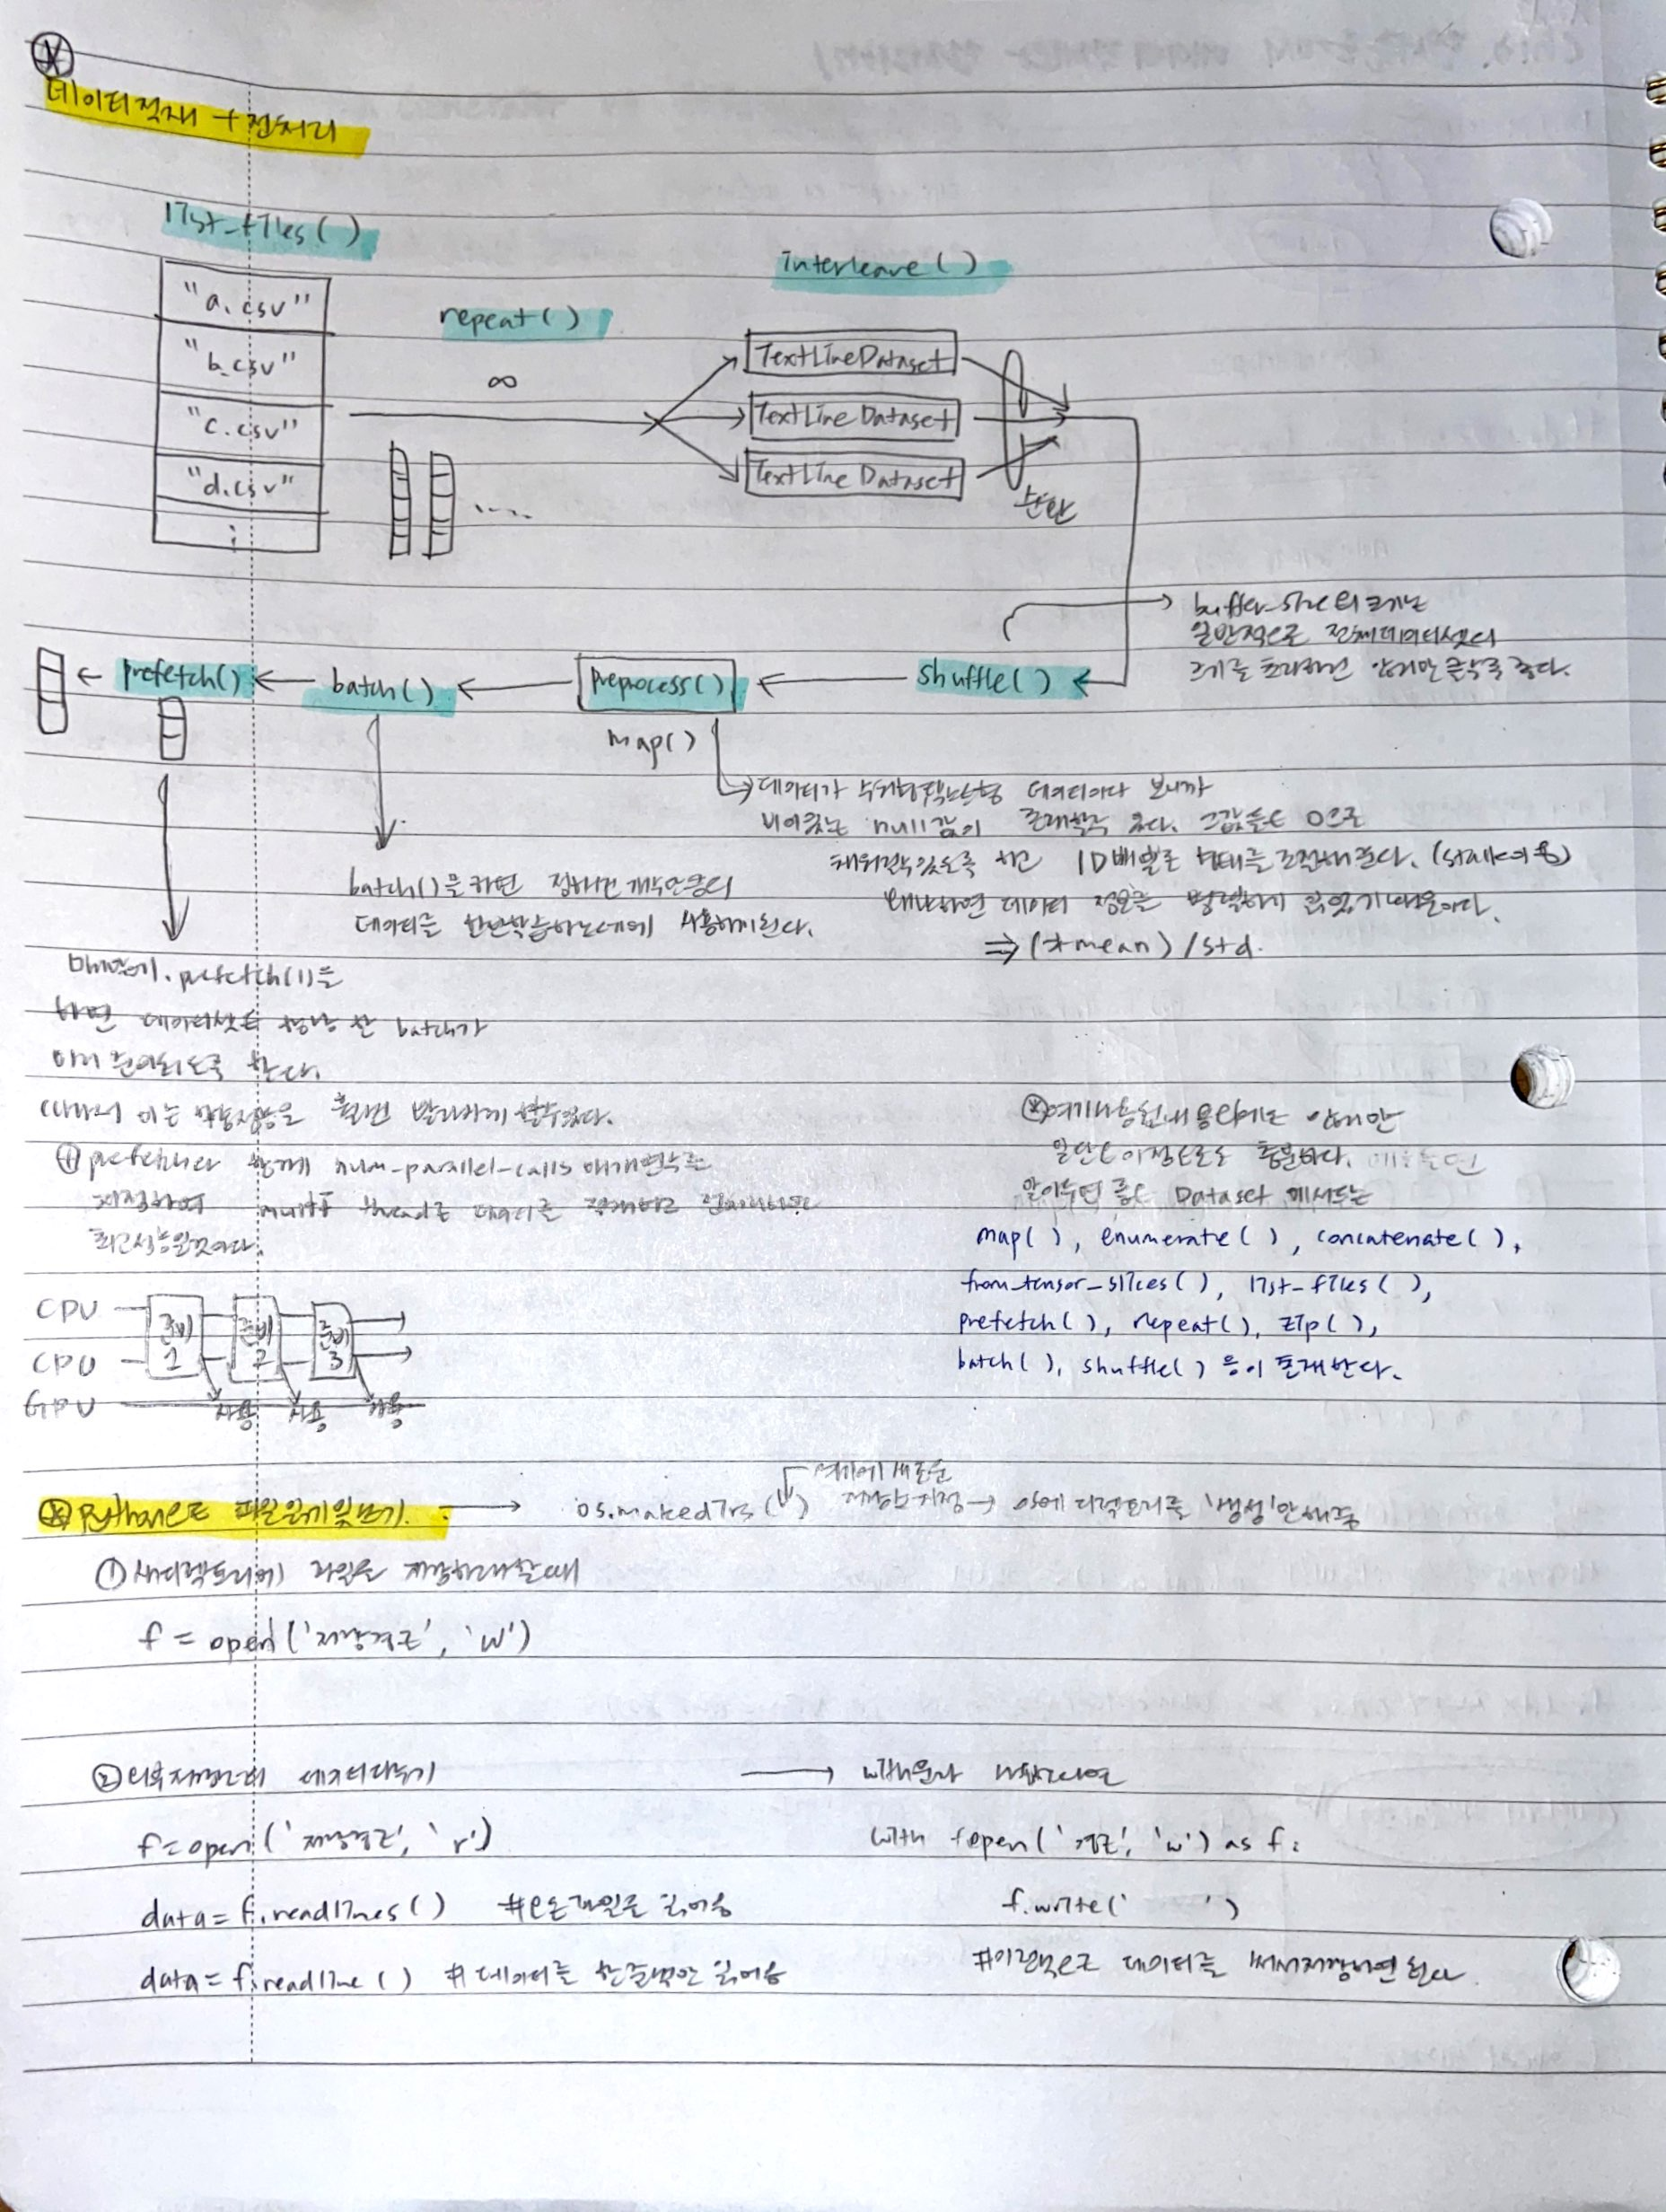

In [195]:
file = tf.data.Dataset.list_files('C:\\Users\\이지혜\\.keras\\datasets\\img_align_celeba\\*.jpg')

**tf.data.Dataset.list_files(저장 경로의 패턴)을 입력하게 되면 실제로 그 패턴에 맞는 모든 데이터의 저장 경로가 data.Dataset의 형태로 저장이 되기 때문에 매우 편리하다.**

In [198]:
for i in file.take(1):
    print(str(i))

tf.Tensor(b'C:\\Users\\\xec\x9d\xb4\xec\xa7\x80\xed\x98\x9c\\.keras\\datasets\\img_align_celeba\\003195.jpg', shape=(), dtype=string)


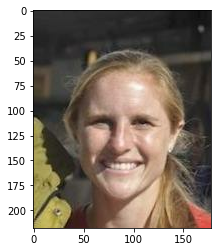

In [205]:
import cv2
for i in file.take(1):
    img = tf.io.read_file(i)
    img = tf.image.decode_jpeg(img)
    img = tf.cast(img, tf.float32)
    plt.imshow(img/255.0)
    
    

In [210]:
roots = 'C:\\Users\\이지혜\\.keras\\datasets\\img_align_celeba'
data = os.listdir(roots)


In [217]:
f = open("C:\\Users\\이지혜\\.keras\\datasets\\jena_climate_2009_2016.csv", 'r')
dataval = f.readlines()
dataval = [i.split('\n') for i in dataval]


In [218]:
dataval

[['"Date Time","p (mbar)","T (degC)","Tpot (K)","Tdew (degC)","rh (%)","VPmax (mbar)","VPact (mbar)","VPdef (mbar)","sh (g/kg)","H2OC (mmol/mol)","rho (g/m**3)","wv (m/s)","max. wv (m/s)","wd (deg)"',
  ''],
 ['01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.30,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.30',
  ''],
 ['01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.40,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.10',
  ''],
 ['01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.90,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.60',
  ''],
 ['01.01.2009 00:40:00,996.51,-8.31,265.12,-9.07,94.20,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.00',
  ''],
 ['01.01.2009 00:50:00,996.51,-8.27,265.15,-9.04,94.10,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.30',
  ''],
 ['01.01.2009 01:00:00,996.50,-8.05,265.38,-8.78,94.40,3.33,3.14,0.19,1.96,3.15,1307.86,0.21,0.63,192.70',
  ''],
 ['01.01.2009 01:10:00,996.50,-7.62,265.81,-8.30,94.80,3.44,3.26,0.18,2.04,3.27,1305.68,0.18,0.63,166.50',
 

### 13.2 TFRecord Format
- 이는 **길이가 다른**연속된 이진 레코드를 저장하는데에 이용한다.
- 일반적으로 대용량의 데이터인 이미지, 오디오, 텍스트 데이터를 빠르고 효율적으로 읽기 위해서 선호하는 format이다.


In [224]:
with tf.io.TFRecordWriter("my_data.tfrecord") as f:
    f.write(b"This is the first record")
    f.write(b"And this is the second record")

In [225]:
filepaths = ["my_data.tfrecord"]
dataset = tf.data.TFRecordDataset(filepaths)
for i in dataset:
    print(i)

tf.Tensor(b'This is the first record', shape=(), dtype=string)
tf.Tensor(b'And this is the second record', shape=(), dtype=string)


- TFRecord에서 사용하는 전형적인 프로토콜 버퍼는 데이터셋의 하나의 sample을 표현하는 **Example프로토콜 버퍼**이다. 이는 BytesList, Int64List, FloatList등과 같은 이름을 가진 특성의 리스트를 갖는다.
- 일반적으로 tensorflow를 이용할 때에는 tf.train.Example 타입의 프로토콜 버퍼를 만들고 파싱할 수 있는 함수를 제공한다.

In [ ]:
from tensorflow.train import BytesList, FloatList, Int64LIst
from tensorflow.train import Feature, Features, Example

data_example = Example(
    features = Features(
        feature = {
            "name": Feature(bytes_list=BytesList(value = [b"Alice"])),
            "id": Feature(int64_list = Int64List(value = [123])),
            "emails": Feature(bytes_list = BytesList(value = [b"a@.com"])).
            "image": Feature(bytes_list =  BytesList(value = [image,numpy()]))
        }
    )
)

- 위와 같은 방법으로 Features라는 특성 이름과 특성값을 매핑한 dictionary를 만든다.
- image의 데이터를 encoding하는 방법은 두가지가 있는데
    1. ```tf.io.encode_jpeg(img)```
    2. ```tf.io.serialize_tensor(img)```
    가 존재한다.
- 이렇게 Example프로토콜 버퍼를 만든 뒤에는 ```SerializeToString()```메서드를 이용해서 직렬화 하고 그 직렬화된 데이터를 TFRecord 파일에 저장을 할때에 예를 들면 
```
with tf.io.TFRecordWriter("저장경로") as f:
    f.write(SerializeToString(데이터))  
```
이런 식으로 저장을 하는데, 무조건 SerializeToString을 해주는 것이 중요하다.

- 마지막으로 중요한 것은 ```tf.io.serialize_tensor()```을 이용하면 어떤 텐서라도 직렬화 하고 바이트 스트링을 BytesList에 넣어서 파싱하는 것이 가능하다는 것이다.

### 13.3 입력 특성 전처리
- 신경망을 학습하기 위해서는 모든 특성을 "수치 특성"으로 변환하고 정규화하는 과정이 필요하다.
- 특히 데이터에 범주형 특성이나 텍스트 특성이 존재하면 숫자로 바꾸어야 하는데, 전처리를 위해서는 Numpy, Pandas, Sklearn, DataAPI등 많은 방법들이 존재하지만 그중에서도 **전처리층을 모델에 포함**하는 방법에 대해 알아보고자 한다.

- 간단한 예시로 Standardization을 하는 것을 보자.
     - 미리 평균, 표준편차를 구해서 계산해도 되지만 class Standardization(keras.layers.Layers)를 만들어 주어도 된다.
     - 그러나 이를 잘못 맞춰주면 나중에 입력값에 nan이 발생해서 학습이 제대로 이루어지지 않을 수 있기 때문에 해줄거면 제대로 해야 한다.
     
#### 13.3.1 one-hot vector을 이용해 범주형 데이터 인코딩하기    
- tf.keras.layers.TextVectorization이라는 층이 kerasAPI에 존재하기 때문에 이를 이용하면 된다.
- 일반적으로 '범주형' 데이터를 수치형 데이터로 바꿀때에 원-핫을 사용하는 것은 범주의 크기가 작을 때에만 이용한다.

#### 13.3.2 Embedding을 이용해 범주형 데이터 인코딩하기
- 임베딩은 훙련이 가능하기 때문에 훈련 중에 점차 향상이 된다. 
- 비슷한 범주의 데이터는 경사 하강법에 의해 더 가까워지고, 거리가 먼 범주의 데이터는 점점 더 멀어지게 된다.
- 하지만 임베딩은 단어 임베딩에 주로 사용이 되는데, 직접 단어 임베딩을 매번 하진 않고 사전 훈련된 임베딩을 재사용하는 경우가 많다.

1. 랜덤하게 각 범주의 임베딩을 담을 'Embedding Matrix'를 만든다.
2. 이 행렬은 범주와 oov 버킷마다 하나의 행이 있고 임베딩 차원마다 하나의 열을 가진다.
    - 즉, 총단어의 범주의 개수가 8개(원래 6+추가여분 2)이고 임베딩 차원이 2라면 8 x 2크기의 행렬로 임베딩 행렬이 만들어진다.
3. 이렇게 만들어진 embedding matrix는 어떤 범주인덱스로 호출될 때 이 행렬에 있는 인덱스의 행을 반환한다.    

In [227]:
embedding_dim, num_oov_bucket = 2,2
vocab = ['cat','ocean','dog','bay','animal','flower']
embed_init = tf.random.uniform([len(vocab) + num_oov_bucket, embedding_dim])
embedding_matrix = tf.Variable(embed_init)

In [230]:
embed_init

<tf.Tensor: shape=(8, 2), dtype=float32, numpy=
array([[0.95831835, 0.01680839],
       [0.3156035 , 0.16013157],
       [0.7148702 , 0.7892921 ],
       [0.11484027, 0.33310425],
       [0.21091413, 0.62329304],
       [0.9865029 , 0.12230623],
       [0.20660043, 0.87113273],
       [0.0206511 , 0.21824265]], dtype=float32)>

In [228]:
embedding_matrix

<tf.Variable 'Variable:0' shape=(8, 2) dtype=float32, numpy=
array([[0.95831835, 0.01680839],
       [0.3156035 , 0.16013157],
       [0.7148702 , 0.7892921 ],
       [0.11484027, 0.33310425],
       [0.21091413, 0.62329304],
       [0.9865029 , 0.12230623],
       [0.20660043, 0.87113273],
       [0.0206511 , 0.21824265]], dtype=float32)>

In [235]:
categories = tf.constant(['owl','animal', 'flower', 'bay'])
indices = tf.range(len(vocab), dtype = tf.int64)
table_init = tf.lookup.KeyValueTensorInitializer(vocab, indices)
table = tf.lookup.StaticVocabularyTable(table_init, 2)
cat_indices = table.lookup(categories)

In [236]:
cat_indices

<tf.Tensor: shape=(4,), dtype=int64, numpy=array([7, 4, 5, 3], dtype=int64)>

- cat_indices는 만들어준 lookup table에서 찾은 categories에 있는 단어의 인덱스를 찾아준 것이다.
- 아래의 행렬을 tf.nn.embedding_lookup()을 이용해서 embedding_matrix에서 cat_indicies에 해당하는 인덱스의 임베딩을 반환한다.

In [237]:
tf.nn.embedding_lookup(embedding_matrix, cat_indices)

<tf.Tensor: shape=(4, 2), dtype=float32, numpy=
array([[0.0206511 , 0.21824265],
       [0.21091413, 0.62329304],
       [0.9865029 , 0.12230623],
       [0.11484027, 0.33310425]], dtype=float32)>

- keras layer을 이용해서 Embedding 층을 만들면 **이 층이 생성될 때에 임베딩 행렬을 랜덤하게 초기화 하고 어떤 범주 인덱스로 호출이 될 때 임베딩 행렬에 있는 그 인덱스의 행을 반환**한다.

In [239]:
embedding = tf.keras.layers.Embedding(input_dim = len(vocab) + num_oov_bucket, output_dim = embedding_dim)

embedding(cat_indices)

<tf.Tensor: shape=(4, 2), dtype=float32, numpy=
array([[-0.00759633, -0.04483807],
       [-0.04123707, -0.04028033],
       [ 0.04376564, -0.03149839],
       [ 0.03396933, -0.0172793 ]], dtype=float32)>